## Enron Person of Interest Identifier
The goal of this project is to create a machine learning model to predict whether or not a person in the Enron dataset is a person of interest (POI) to the US Justice Department from the Enron corporate fraud case. 

### Preliminary step: Load helper functions into the notebook
More indepth descriptions on what these functions do can be found below.  These functions were obtained from udacity.com.

In [42]:
""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting the dictionary to a numpy 
    array, I will separate the labels from the
    features--this is what targetFeatureSplit is for

    because I want to have the poi label as the target,
    and the features I want to use are the person's
    salary and bonus, here's what I'll do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""




import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()
    for f in my_dataset[person]:
        if my_dataset[person][f] == 'NaN' and remove_NaN:
            my_dataset[person][f] = 0.0
    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

### Step 1: Load the dataset



In [43]:
import sys
import pickle
import pandas as pd

with open("final_project_dataset.pkl", "r") as data_file:  # Load the dictionary containing the dataset
    data_dict = pickle.load(data_file)






### Step 2: Begin exploring the dataset

#### Perform preliminary analysis on the dataset

In [44]:
my_dataset = data_dict  # Rename dictionary to my_dataset

 
# Select which features to add from this list.  I will add most of them and use a feature selection algorithm to 
# determine which features I will actually use.
print 'Features to select from: '
print my_dataset['LAY KENNETH L'].keys()

Features to select from: 
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


#### Select features from the list above and add any additional created features that seem potentially useful
I won't be too discriminatory in the features I add to this list.  Instead I will use a function (SelectPercentile) to select the features with the most information below.  Additionally, I will use a parameter tuning function (GridSearchCV) to select the appropriate percentile of features to use for each algorithm I test.

In [45]:
features_list = ['poi','salary','expenses','pct_to_poi','pct_from_poi',
                'pct_shared_poi','exercised_stock_options', 'deferral_payments',
                'deferred_income','director_fees','loan_advances',
                'long_term_incentive','bonus','other','restricted_stock',
                'restricted_stock_deferred','total_payments','total_stock_value'] 

# features_list is a list of strings, each of which is a feature name.
# As noted above, "poi" is first indicating it is the label we are 
# trying to predict.

#### A note on potential leakage:  
The features I created are based on the number of emails the person has from, to, or shared receipt with POI’s.  This assumes that we already know who all the POI’s are.  However, if we were truly trying to predict a new data point, we wouldn’t know whether or not that person is POI, therefore they could not be accounted for in the email data.  This presents a potential leakage problem with training data and testing data splits.  For the purposes of this problem, we will assume that the email features represent the relationship with know POI’s, not all POI’s.  This is an imperfect assumption, but practical all things considered. 

#### Look for any problematic data points

In [46]:
for i in my_dataset.keys():
    my_dataset[i]['features_used'] = len([v for k, v in my_dataset[i].items() if v != 'NaN'])

print "Data points with few features used: "
print [k for k in my_dataset.keys() if my_dataset[k]['features_used']<=4]  



Data points with few features used: 
['WODRASKA JOHN', 'WHALEY DAVID A', 'CLINE KENNETH W', 'WAKEHAM JOHN', 'WROBEL BRUCE', 'SCRIMSHAW MATTHEW', 'GILLIS JOHN', 'LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK', 'SAVAGE FRANK', 'GRAMM WENDY L']


In [47]:
# Remove 'THE TRAVEL AGENCY IN THE PARK' because it is not a person

my_dataset.pop('THE TRAVEL AGENCY IN THE PARK',0)


{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'features_used': 3,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

#### Create new features
From reading the feature descriptions from the available features of my_dataset, it looks like we will need to transform a few to make them more useful.  

In [48]:
for person in my_dataset:
    my_dataset[person]['pct_to_poi'] =  0.0
    my_dataset[person]['pct_from_poi'] = 0.0
    my_dataset[person]['pct_shared_poi'] = 0.0
    if (my_dataset[person]['from_poi_to_this_person'] != 'NaN') and (my_dataset[person]['from_messages'] != 'NaN') and (my_dataset[person]['from_messages'] != 0):
        my_dataset[person]['pct_from_poi'] =  float(my_dataset[person]['from_poi_to_this_person']) /  float(my_dataset[person]['to_messages'])
    if (my_dataset[person]['from_this_person_to_poi'] != 'NaN') and (my_dataset[person]['to_messages'] != 'NaN') and (my_dataset[person]['to_messages'] != 0):
        my_dataset[person]['pct_to_poi'] =  float(my_dataset[person]['from_this_person_to_poi']) /  float(my_dataset[person]['from_messages'])
    if (my_dataset[person]['shared_receipt_with_poi'] != 'NaN') and (my_dataset[person]['to_messages'] != 'NaN') and (my_dataset[person]['to_messages'] != 0):    
        my_dataset[person]['pct_shared_poi'] =  float(my_dataset[person]['shared_receipt_with_poi']) /  float(my_dataset[person]['to_messages'])
        
    for f in my_dataset[person]:
        if my_dataset[person][f] == 'NaN':
            my_dataset[person][f] = 0.0


#### Get an overview of our modified dataset

In [49]:
# Extract features and labels from dataset for local testing.

data = featureFormat(my_dataset, features_list, sort_keys = True,remove_NaN=True)
data = np.nan_to_num(data)
labels, features = targetFeatureSplit(data)

# Look at the overall allocation of the dataset

print 'Information regarding the dataset:'
print 'Number of data points: ', len(labels)
print 'Number of features available: ', len(my_dataset['LAY KENNETH L'].keys())
print "Number of POI's: ", len([label for label in labels if label ==1])
print ""



Information regarding the dataset:
Number of data points:  144
Number of features available:  25
Number of POI's:  18



In [50]:
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,201955.0,13868.0,0.029613,0.016196,0.484838,1729541.0,2869717.0,-3081055.0,0.0,0.0,304805.0,4175000.0,152.0,126027.0,-126027.0,4484442.0,1729541.0
1,0.0,0.0,3486.0,0.000000,0.000000,0.000000,257817.0,178980.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0
2,0.0,477.0,56301.0,0.000000,0.068905,0.821555,4046157.0,0.0,-5104.0,0.0,0.0,0.0,0.0,864523.0,1757552.0,-560222.0,916197.0,5243487.0
3,0.0,267102.0,11200.0,0.000000,0.000000,0.000000,6680544.0,1295738.0,-1386055.0,0.0,0.0,1586055.0,1200000.0,2660303.0,3942714.0,0.0,5634343.0,10623258.0
4,0.0,239671.0,129142.0,0.000000,0.000000,0.000000,0.0,260455.0,-201641.0,0.0,0.0,0.0,400000.0,69.0,145796.0,-82782.0,827696.0,63014.0


There are several null values in the dataset.  We replaced these with 0's.  This is not quite ideal -- we'd likely be able to create a model with more predictive power if we had a richer dataset.

### Step 3: Visualize data for continued exploration
Visualize the data looking for anything unusual, and investigating these idiosycrasies further to determine if they are outliers.  Also, look for patterns that hold POI's apart from Non-POI's.  

When outliers are discovered, write code to remove them from my_dataset then rerun data.

In [51]:
# Functions that will be helpful in streamlining the exploration process

def visualize(x,y,data):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.lmplot(x=x,y=y,data=data, hue= 'color', fit_reg = False) 
    sns.plt.title("{} vs. {}".format(x,y))
    
def maximum(x,y,data,dic):
    max_x = max(data[x])
    max_y = max(data[y])
    for person in dic:
        if dic[person][x] == max_x:
            print "Maximum {}:".format(x), person
        if dic[person][y] == max_y:
            print "Maximum {}:".format(y), person


Maximum expenses: TOTAL
Maximum salary: TOTAL


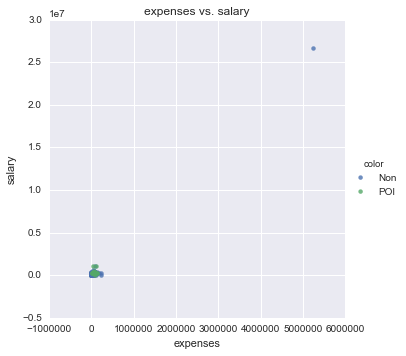

In [53]:
# Visualize, explore and search for outliers.

data = featureFormat(my_dataset, features_list, sort_keys = True,remove_NaN=True)



df = pd.DataFrame(data,columns=features_list)
df['color'] = df["poi"].apply(lambda poi: 'POI' if poi == 1 else 'Non')

visualize('expenses','salary',df)
maximum('expenses','salary',df,my_dataset)

It looks like we have an outlier.  One data point is several orders of magnitude above the rest. 

We can see that our outlier is 'TOTAL'.  I will remove this below.


Remove 'TOTAL' and reload data...

Maximum expenses: MCCLELLAN GEORGE
Maximum salary: SKILLING JEFFREY K


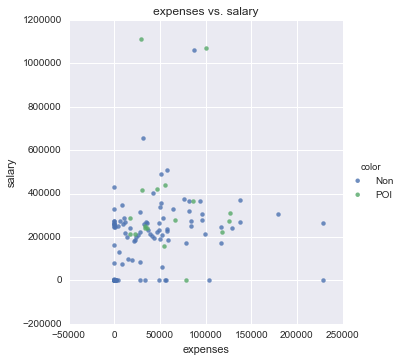

In [18]:
# Remove 'TOTAL', reload data, and run again. 
print ""
print "Remove 'TOTAL' and reload data..."
print ""

my_dataset.pop('TOTAL',0) # Remove 'TOTAL' 
data = featureFormat(my_dataset, features_list, sort_keys = True,remove_NaN=True)
data = np.nan_to_num(data)
labels, features = targetFeatureSplit(data)
df = pd.DataFrame(data,columns=features_list)
df['color'] = df["poi"].apply(lambda poi: 'POI' if poi == 1 else 'Non')

visualize('expenses','salary',df)
maximum('expenses','salary',df,my_dataset)

Now the person with the highest maximum salary is 'SKILLING JEFFREY K' who is a POI that we definitely want to keep.

Neither salary nor expenses look like they have much predictive power.

Maximum pct_to_poi: HUMPHREY GENE E
Maximum pct_from_poi: DONAHUE JR JEFFREY M


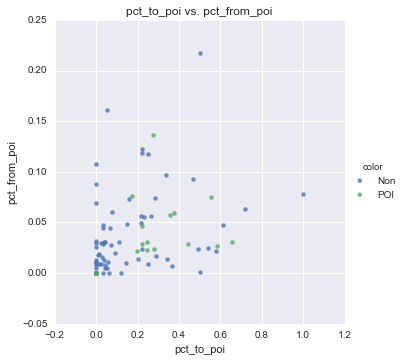

In [185]:
### Continue exploration of data and investigation of outliers.

visualize('pct_to_poi','pct_from_poi',df)
maximum('pct_to_poi','pct_from_poi',df,my_dataset)


Maximum bonus: LAVORATO JOHN J
Maximum deferral_payments: FREVERT MARK A


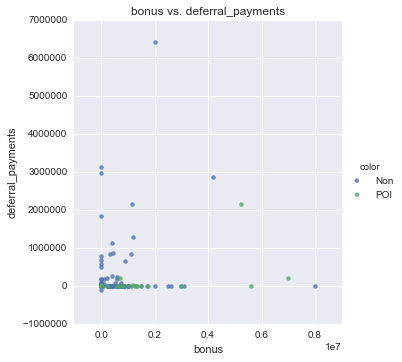

In [17]:
# Continue exploration of data and investigation of outliers.

visualize('bonus','deferral_payments',df)
maximum('bonus','deferral_payments',df,my_dataset)

Maximum exercised_stock_options: LAY KENNETH L
Maximum total_stock_value: LAY KENNETH L


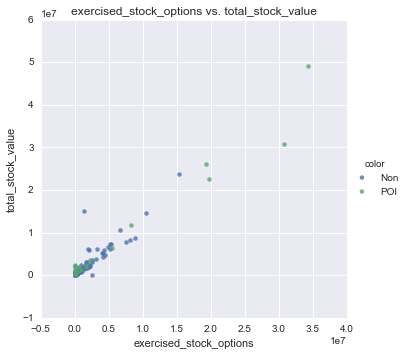

In [19]:
# Continue exploration of data and investigation of outliers

visualize('exercised_stock_options','total_stock_value',df)
maximum('exercised_stock_options','total_stock_value',df,my_dataset)


One data point above is quite a bit larger on both measures.  We can see this is Kenneth Lay, chairmen of the board and definitely a POI.  We will want to leave him in.

Maximum restricted_stock: LAY KENNETH L
Maximum long_term_incentive: MARTIN AMANDA K


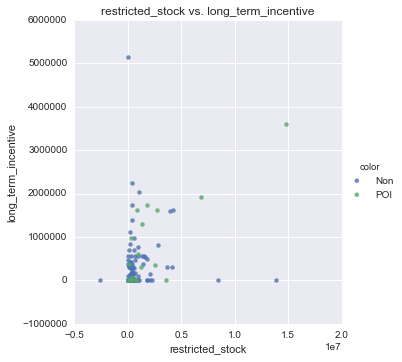

In [21]:
# Continue exploration of data and investigation of outliers

visualize('restricted_stock','long_term_incentive',df)
maximum('restricted_stock','long_term_incentive',df,my_dataset)


### Step 4: Test different prediction algorithms on the dataset then evaluate and validate


#### Test
I will test several different machine learning prediction classifiers on the dataset in an attempt to create an algorithm that correctly classifies POI's as POI's and Non-POI's as Non-POI's.  On each algorithm I'll use the sklearn function GridSearchCV which allows me to try out a each combination of the the parameter values passed in.

The algorithms I will test are: Gaussian Naive Bayes, K Nearest Neighbors, Logistic Regression, Adaptive Boosting and Extreme Gradient Boosting.  I will use Principal Component Analysis and SelectPercentile to select the features added to each algorithm.

Before implementing feature selection or PCA, I will need to scale the features.  PCA (along several of the algorithms I will test) will need feature scaling to work properly because it requires the variance of each feature to be standardized.  K Nearest Neighbors and Logistic Regression would require feature scaling even if I weren't using PCA, and feature scaling has no affect on the other algorithms.

Principal Component Analysis, or PCA, reduces the number of features used by the algorithm by compressing the information from many features into a few.

SelectPercentile scores the power of each feature based on the dataset, and selects the features within the specified percentile passed in.





#### Evaluate
The primary evaluation criterion I will consider are precision and recall.  Precision is the
percentatge of people we predict to be POI's that are actually POI's.  Recall is percentage of
all the POI's that we identify as POI's.

In my opinion, recall is more important than precision in this situation.  I think it should
be left up to the justice system to determine false positives predicted by our model.  Of
course, precision is still important. However, I am making the value judgement that recall is
more important.  

#### Validate
I want to make sure the result is valid.  Therefore the test predictions should not be made on the same data that the algorithm was trained on.  Because the sample size is relatively small, a cross validation technique will be useful to maintain a higher number of data points to train on.  The dataset is also very lopsided (most people in the dataset are not POI's), so a stratified sample will be preferable.  StratifiedShuffleSplit  accomplishes both of these tasks.

The functions below are used for the purpose of evaluating and validating the algorithms below.  These functions were obtained from udacity.com.

In [23]:
""" a basic script for testing the POI identifier,
    and checking the results that are produced by it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
#from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


    
    

In [36]:
# Load in sci-kit learn modules
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score,classification_report
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.preprocessing import MinMaxScaler


#### Gaussian Naive Bayes

In [46]:
# Naive Bayes with feature union -- (runs SelectPercentile and PCA simeltaneously 
# instead of sequentially). For each algorithm below, test with and without feature
# union and use which ever returns the better cross-validated result.

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
percentile = SelectPercentile(percentile=100)
pca = PCA(n_components=1)
combo = FeatureUnion([('select',percentile),('PCA',pca)])
steps = [('scaler',scaler),('feature',combo),('algorithm',gnb)]
pipeline = Pipeline(steps)

# Code used to tune algorithm -- uncomment to run:
#parameters = {'feature__select__percentile':[25,50,75,100],
#              'feature__PCA__n_components':[1,2,3]}
#cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)            
#grid = GridSearchCV(pipeline, param_grid=parameters, scoring='recall',cv=cv)
#grid = grid.fit(features,labels)
#clf_best = grid.best_estimator_

nb_pipe = pipeline.fit(features,labels)

print 'Naive Bayes:'
print test_classifier(nb_pipe, my_dataset, features_list, folds = 1000)


Naive Bayes:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature', FeatureUnion(n_jobs=1,
       transformer_list=[('select', SelectPercentile(percentile=100,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_components=1, whiten=False))],
       transformer_weights=None)), ('algorithm', GaussianNB())])
	Accuracy: 0.57033	Precision: 0.20852	Recall: 0.79500	F1: 0.33039	F2: 0.50880
	Total predictions: 15000	True positives: 1590	False positives: 6035	False negatives:  410	True negatives: 6965

None


#### K Nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=10,metric='chebyshev',metric_params=None,
                           n_jobs=1, n_neighbors=2, p=1,weights='distance')

scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
percentile = SelectPercentile(percentile=30)

pca = PCA(n_components=3)
#combo = FeatureUnion([('select',percentile),('PCA',pca)])
steps = [('scaler',scaler),('select',percentile),('PCA',pca),('algorithm',knn)]
pipeline = Pipeline(steps)

# Code used to tune algorithm -- uncomment to run:
#parameters = {'select__percentile':[20,30,40],
#              'PCA__n_components':[3,4]},
#              'algorithm__n_neighbors':[2,3,4],
#              'algorithm__p':[1,2],
#              'algorithm__weights':['uniform','distance'],
#              'algorithm__leaf_size':[10,20],
#              'algorithm__metric':['euclidean','manhattan','chebyshev']}

#cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)            
#grid = GridSearchCV(pipeline, param_grid=parameters, scoring='recall',cv=cv)
#grid.fit(features,labels)
#clf_best = grid.best_estimator_

knn_pipe = pipeline.fit(features,labels)


selected = [features_list[i] for i in np.argsort(knn_pipe.named_steps['select'].scores_)[::-1] if features_list[i]!='poi'][0:(int(len(features_list)*.3)-1)] 
scores = sorted(knn_pipe.named_steps['select'].scores_,reverse=True)[0:4]

print 'Features selected sorted by score:', selected
print 'Accompanying scores: ', scores
print ' '
print 'K Nearest Neighbors:'
print test_classifier(knn_pipe, my_dataset, features_list, folds = 1000)



Features selected sorted by score: ['pct_shared_poi', 'total_payments', 'long_term_incentive', 'expenses']
Accompanying scores:  [24.815079733218194, 24.182898678566872, 20.792252047181538, 18.289684043404513]
 
K Nearest Neighbors:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('select', SelectPercentile(percentile=30,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_components=3, whiten=False)), ('algorithm', KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='chebyshev',
           metric_params=None, n_jobs=1, n_neighbors=2, p=1,
           weights='distance'))])
	Accuracy: 0.83433	Precision: 0.36039	Recall: 0.31300	F1: 0.33503	F2: 0.32145
	Total predictions: 15000	True positives:  626	False positives: 1111	False negatives: 1374	True negatives: 11889

None

PCA Eigenvalue(s):  [ 0.4577492   0.28794443  0.17295977]


#### Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(class_weight='balanced',penalty='l2',C=.22)

scaler = MinMaxScaler(feature_range=(0, 1), copy=True) 
percentile = SelectPercentile(percentile=50)
pca = PCA(n_components=2)
# For feature selection, use FeatureUnion to run PCA and and SelectPercentile simeltaneously 
combo = FeatureUnion([('select',percentile),('PCA',pca)])

# Then create a pipeline to streamline the feature selection and algorithm
steps = [('scaler',scaler),('feature',combo),('algorithm',log)]
pipeline = Pipeline(steps)

# Code used to tune algorithm -- uncomment to run:
#parameters = {'feature__select__percentile':[25,50,75],
              #'feature__PCA__n_components':[1,2,3],
              #'algorithm__penalty':['l1','l2'],
              #'algorithm__C':[.21,.22,.23]}

#cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)            
#grid = GridSearchCV(pipeline, param_grid=parameters, scoring='f1',cv=cv)
#grid.fit(features,labels)
#clf_best = grid.best_estimator_

log_pipe= pipeline.fit(features,labels)

selected = [features_list[i] for i in np.argsort(percentile.scores_)[::-1] if features_list[i]!='poi'][0:(int(len(features_list)*.5)-1)] 
scores = sorted(percentile.scores_,reverse=True)[0:(int(len(features_list)*.5)-1)]
print ''
print 'Features selected sorted by score:', selected
print ''
print 'Accompanying scores: ', scores
print 'Logistic Regression:'
print test_classifier(log_pipe, my_dataset, features_list, folds = 1000)



Features selected sorted by score: ['pct_shared_poi', 'total_payments', 'long_term_incentive', 'expenses', 'deferral_payments', 'loan_advances', 'other', 'pct_from_poi']

Accompanying scores:  [24.815079733218194, 24.182898678566872, 20.792252047181538, 18.289684043404513, 16.409712548035792, 11.458476579280697, 9.9221860131898385, 9.212810621977086]
Logistic Regression:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature', FeatureUnion(n_jobs=1,
       transformer_list=[('select', SelectPercentile(percentile=50,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_components=2, whiten=False))],
       transform...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
	Accuracy: 0.70580	Precision: 0.26988	Recall: 0.70750	F1: 0.39072	F2: 0.53424
	Total predictions: 15000	True positives: 1415	False positives: 3828	False negatives:  585	True negatives: 9172

None


#### Adaptive Boosting Classifier

In [162]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(learning_rate=0.6, n_estimators=30)

 
scaler = MinMaxScaler(feature_range=(0, 1), copy=True) 
percentile = SelectPercentile(percentile=85)
pca = PCA(n_components=1)
# For feature selection, use FeatureUnion to run PCA and and SelectPercentile simeltaneously 
combo = FeatureUnion([('select',percentile),('PCA',pca)])

# Then create a pipeline to streamline the feature selection and algorithm
steps = [('scaler',scaler),('feature',combo),('algorithm',ada)]
pipeline = Pipeline(steps)

# Code used to tune algorithm -- uncomment to run:
#parameters = {'feature__select__percentile':[75,100],
              #'feature__PCA__n_components':[1,2]}#,
              #'algorithm__learning_rate':[.4,.5,.6],
              #'algorithm__n_estimators':[20,25,30]}

#cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)            
#grid = GridSearchCV(pipeline, param_grid=parameters, scoring='f1',cv=cv)
#grid.fit(features,labels)
#clf_best = grid.best_estimator_

ada_pipe= pipeline.fit(features,labels)

selected = [features_list[i] for i in np.argsort(percentile.scores_)[::-1] if features_list[i]!='poi'][0:(int(len(features_list)*.85)-1)] 
scores = sorted(percentile.scores_,reverse=True)[0:(int(len(features_list)*.85)-1)]
print ''
print 'Features selected sorted by score:', selected
print ''
print 'Accompanying scores: ', scores
print ''
print 'Adaptive Boosting:'
print test_classifier(ada_pipe, my_dataset, features_list, folds = 1000)



Features selected sorted by score: ['pct_shared_poi', 'total_payments', 'long_term_incentive', 'expenses', 'deferral_payments', 'loan_advances', 'other', 'pct_from_poi', 'restricted_stock_deferred', 'director_fees', 'salary', 'bonus', 'pct_to_poi', 'deferred_income']

Accompanying scores:  [24.815079733218194, 24.182898678566872, 20.792252047181538, 18.289684043404513, 16.409712548035792, 11.458476579280697, 9.9221860131898385, 9.212810621977086, 9.1012687391935376, 8.7727777300916809, 7.1840556582887247, 6.0941733106389666, 4.1874775069953785, 3.128091748156737]

Adaptive Boosting:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature', FeatureUnion(n_jobs=1,
       transformer_list=[('select', SelectPercentile(percentile=85,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_components=1, whiten=False))],
       transformer_weights=None)), ('algorithm', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
      

#### Extreme Gradient Boosting

In [165]:
import xgboost as xgb

xgb = xgb.XGBClassifier(learning_rate=.7,gamma=.1,min_child_weight=2,max_depth=1,subsample=.9,
                       colsample_bytree=.9,n_estimators=595)

scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
percentile = SelectPercentile(percentile=100)
pca = PCA(n_components=3)
# For feature selection, use FeatureUnion to run PCA and and SelectPercentile simeltaneously 

# Then create a pipeline to streamline the feature selection and algorithm
steps = [('scaler',scaler),('feature',combo),('algorithm',xgb)]
pipeline = Pipeline(steps)

# Code used to tune the algorithm:
#parameters = {'feature__select__percentile':[25,50,75,100],
              #'feature__PCA__n_components':[1,2,3],
              #'algorithm__learning_rate':[.7,.8],
              #'algorithm__gamma':[.1,.2,.3],
              #'algorithm__min_child_weight':[2,3],
              #'algorithm__max_depth':[1,2],
              #'algorithm__subsample':[.8,.9,1],
              #'algorithm__colsample_bytree':[.9,1,1.1],
              #'algorithm__n_estimators':[595,625]}

#cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)            
#grid = GridSearchCV(pipeline, param_grid=parameters, scoring='recall',cv=cv)
#grid.fit(features,labels)
#clf_best = grid.best_estimator_

xgb_pipe= pipeline.fit(features,labels)

print 'XGBoost:'
print test_classifier(xgb_pipe, my_dataset, features_list, folds = 1000)


XGBoost:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature', FeatureUnion(n_jobs=1,
       transformer_list=[('select', SelectPercentile(percentile=85,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_components=1, whiten=False))],
       transform...stimators=595, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.9))])
	Accuracy: 0.86173	Precision: 0.47315	Recall: 0.32600	F1: 0.38603	F2: 0.34762
	Total predictions: 15000	True positives:  652	False positives:  726	False negatives: 1348	True negatives: 12274

None


#### Hybrid Classifier (Final)
This classifier is a hybrid of some of the models above.  Each of the models "votes" on whether or not the person should be predicted to be a POI.  If a majority of the models included indicate a POI prediction, the final classifier will predict they are a POI.

This approach allows us to take advantage of the strengths of several different models.  For instance, some models are better at recall and some are more precise.  The hybrid model will be relatively good at both.

There is a small negative associated with this approach: time to run.  However, this is not a major issue for this problem since the model does not need to churn out predictions ultra quickly to be useful.  This would be much more of a concern for a machine learning model requiring real time predictions to be useful.  For instance, a model to identify potential opportunities in financial markets.

In [163]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=[('naive_bayes',nb_pipe),('k_neighbors',knn_pipe),
                                   ('xgboost',xgb_pipe)])
print 'Hybrid Classifier:'
print test_classifier(clf, my_dataset, features_list, folds = 1000)



Hybrid Classifier:
VotingClassifier(estimators=[('naive_bayes', Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature', FeatureUnion(n_jobs=1,
       transformer_list=[('select', SelectPercentile(percentile=100,
         score_func=<function f_classif at 0x10b7b8a28>)), ('PCA', PCA(copy=True, n_component...mators=595, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.9))]))],
         voting='hard', weights=None)
	Accuracy: 0.83993	Precision: 0.40989	Recall: 0.45600	F1: 0.43172	F2: 0.44597
	Total predictions: 15000	True positives:  912	False positives: 1313	False negatives: 1088	True negatives: 11687

None
